In [1]:
from __future__ import print_function, division

%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context="poster")
import numpy as np
from scipy import integrate, interpolate, optimize

from astropy import units as u
from astropy import constants as const

AU = u.AU.to(u.cm)
m_p = const.m_p.cgs.value
G = const.G.cgs.value
M_solar = u.M_sun.to(u.g)

mu = 2 # mean molecular weight; mostly H_2 gas
T = 10 # temperature [K]
c_s = np.sqrt(const.k_B.cgs.value * T / (mu * m_p))

R = 10**4 * AU
M = M_solar

def get_pressure(rho):
    return rho * c_s**2

def get_scale_radius(rho_c):
    scale_radius = c_s / np.sqrt(4*np.pi * G * rho_c)
    return scale_radius

def get_xi(rho_c):
    xi = R / get_scale_radius(rho_c)
    return xi

/Users/egentry/anaconda/lib/python3.4/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
def integrand(y, t):
    xi = t
    psi, w  = y
    
    d_psi_d_xi = w
    d_w_d_xi   = (-2*w/xi) + np.exp(-psi)
        
    return np.array([d_psi_d_xi, d_w_d_xi])

In [3]:
xi_0 = 1e-6
xi_f = 10
y_0 = np.array([xi_0**2 / 6, xi_0 / 3])
xis = np.logspace(np.log10(xi_0), np.log10(xi_f), num=1000)
result = integrate.odeint(integrand, y_0, xis)
psis, ws = result.transpose()

mass_enclosed = integrate.cumtrapz(4*np.pi * xis**2. * np.exp(-psis),
                                   xis,
                                   initial=0)

psis_interp          = interpolate.interp1d(xis, psis)
mass_enclosed_interp = interpolate.interp1d(xis, mass_enclosed)

# need to define this *after* we have an interpolating fn
# (also it should be updated whenever the interp fn changes)
def get_physical_mass(xi,rho_c):
    physical_mass = rho_c * mass_enclosed_interp(xi) \
                          * get_scale_radius(rho_c)**3
    return physical_mass

# find the correct rho_c
def test_rho_c(rho_c):
    xi = get_xi(rho_c)
    error_mass = M - get_physical_mass(xi, rho_c)
    return error_mass

rho_c = optimize.fsolve(test_rho_c, m_p)
assert(len(rho_c) == 1) # we only want one root
rho_c = rho_c[0]
print("rho:      {0:.2e} [m_p cm^-3]".format(rho_c / m_p))

xi = get_xi(rho_c)
print("xi:       {0:.2f}".format(xi))

mass = get_physical_mass(xi, rho_c) / M_solar
print("Mass:     {0:.2e} [M_solar]".format(mass))

pressure = get_pressure(rho_c * np.exp(-psis_interp(xi)))
print("Pressure: {0:.2e} [dyne cm^-2]".format(pressure))

rho:      2.78e+05 [m_p cm^-3]
xi:       4.60
Mass:     1.00e+00 [M_solar]
Pressure: 2.99e-11 [dyne cm^-2]


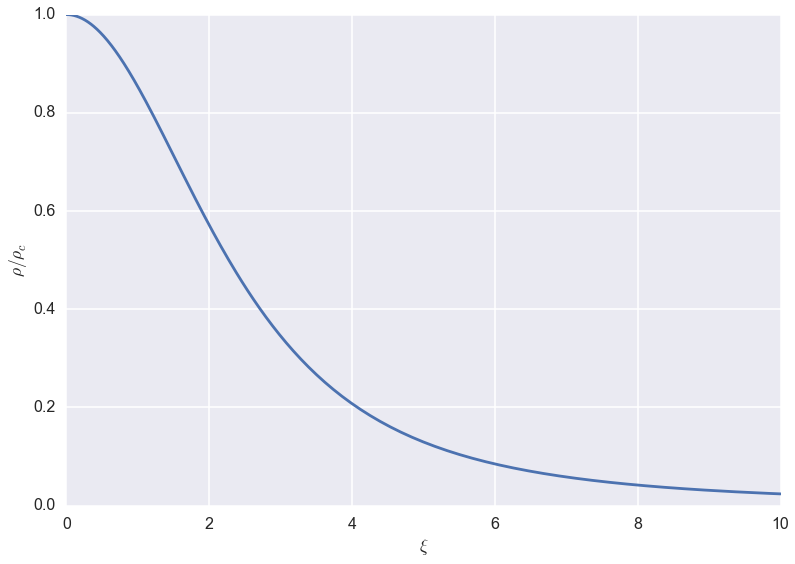

In [4]:
plt.plot(xis, np.exp(-psis))
plt.xlabel(r"$\xi$")
plt.ylabel(r"$\rho / \rho_c$")

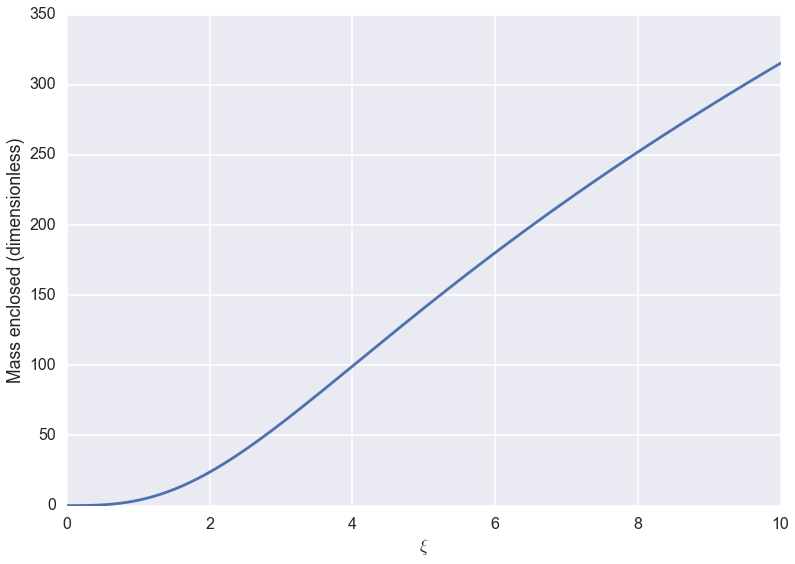

In [5]:
plt.plot(xis, mass_enclosed)
plt.xlabel(r"$\xi$")
plt.ylabel(r"Mass enclosed (dimensionless)")

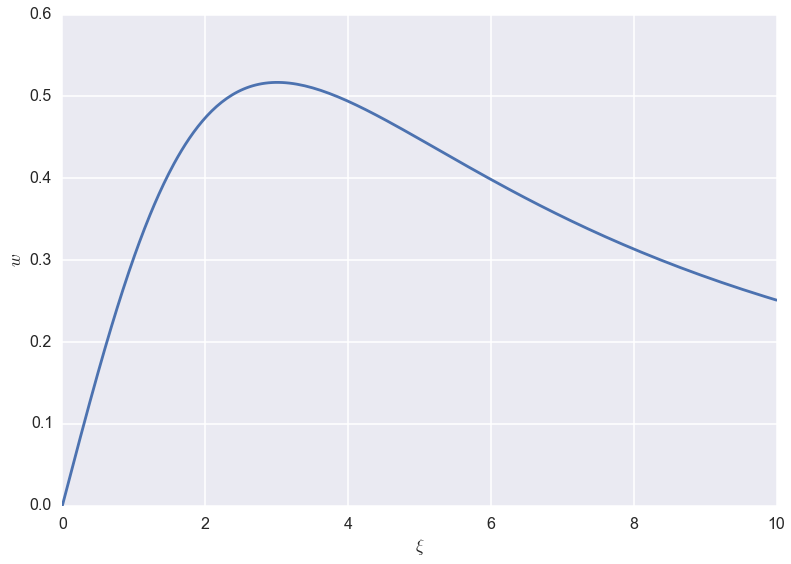

In [6]:
plt.plot(xis, ws)
plt.xlabel(r"$\xi$")
plt.ylabel(r"$w$")

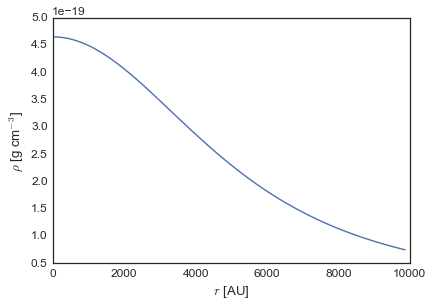

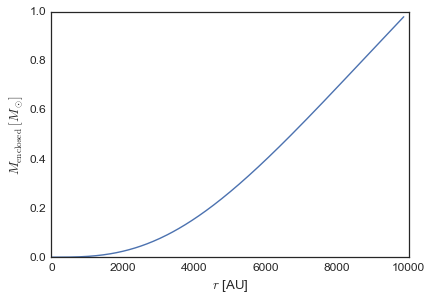

In [7]:
# create printable figures for homework submission
with sns.axes_style("white"):
    with sns.plotting_context(context="paper", font_scale=1.5):
        radius = get_scale_radius(rho_c)*xis
        density = rho_c*np.exp(-psis)

        mask = radius < 1e4*AU

        plt.plot(radius[mask] / AU, density[mask])
        plt.xlabel(r"$r$ [AU]")
        plt.ylabel(r"$\rho$ [g cm$^{-3}$]")
        plt.savefig("density_plot.eps")

        plt.figure()
        plt.plot(radius[mask] / AU, mass_enclosed[mask] * rho_c * get_scale_radius(rho_c)**3 / M_solar)
        plt.xlabel(r"$r$ [AU]")
        plt.ylabel(r"$M_\mathrm{enclosed}$ $[M_\odot]$")
        plt.savefig("mass_plot.eps")
